# Protein Sequence Classification on pfam dataset

## 1. Business Problem

### 1.1 Description

Background:
Proteins are essential biomolecules composed of amino acids linked by peptide bonds. These molecules are critical for various biological functions and their structure and function are determined by the sequence and types of amino acids they contain. The Pfam database categorizes proteins into families based on these sequences, providing a foundation for understanding the functional diversity of proteins.

Problem Statement:
The goal is to develop a deep learning model that predicts the protein family classification from an unaligned amino acid sequence, utilizing the Pfam dataset. This involves mapping each amino acid sequence to one of the 17,929 protein family accessions in Pfam, enhancing our understanding of protein functions.

### 1.2 Sources/Useful Links

- Source: [Pfam seed random split](https://www.kaggle.com/googleai/pfam-seed-random-split)
- Paper: [Using deep learning to annotate the protein universe](https://www.biorxiv.org/content/10.1101/626507v4.full).

## 2. Machine Learning Problem

### 2.1 Data

#### 2.1.1 Data Overview

- **`sequence`:** Input feature consisting of amino acid sequences for a protein domain. This includes 20 common amino acids and 4 rare amino acids (X, U, B, O, Z).

- **`family_accession`:** Label for the model, formatted as PFxxxxx.y, where "xxxxx" is the family accession number and "y" is the version number, which can be one or two digits.

- **`sequence_name`:** Identifier in the format "uniprot_accession_id/start_index-end_index," representing the protein's unique accession ID and amino acid sequence range.

- **`aligned_sequence`:** A sequence from the multiple sequence alignment within its family, retaining gaps to show alignment with other family members.

- **`family_id`:** A single-word identifier for the protein family.

#### 2.1.2 Example Data point



```
sequence: HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE 
family_accession: PF02953.15
sequence_name: C5K6N5_PERM5/28-87
aligned_sequence: ....HWLQMRDSMNTYNNMVNRCFATCI...........RS.F....QEKKVNAEE.....MDCT....KRCVTKFVGYSQRVALRFAE 
family_id: zf-Tim10_DDP
```



#### 2.1.3 Data split

- We have been provided with already done random split(train, val, test) of pfam dataset.
  - Train - 80% (For training the models).
  - Val - 10% (For hyperparameter tuning/model validation).
  - Test - 10% (For acessing the model performance).

### 2.2 Mapping the real world problem to an ML problem

#### 2.2.1 Type of Machine learning Problem

It is a multi class classification problem, for a given sequence of amino acids we need to predict its family accession.

#### 2.2.2 Performance Metric

- Multi class log loss
- Accuracy

## 3. Exploratory Data Analysis

### Importing Libraries

In [1]:
# !pip install numpy pandas matplotlib seaborn prettytable keras scikit-learn ipython tensorflow tensorflow-macos tensorflow-metal

In [2]:
%matplotlib inline

import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading Data

In [4]:
data_path = '/Users/rishabhindoria/Desktop/protein/random_split/'
print('Available data', os.listdir(data_path))

Available data ['.DS_Store', 'test', 'train', 'dev']


In [5]:
# data is randomly splitted in three folders [train(80%), test(10%), dev(10%)]
# reading and concatinating data for each folder.

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

In [6]:
# reading all data_partitions

df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')

### Basic Statistics

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086741 entries, 0 to 13354
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   family_id         1086741 non-null  object
 1   sequence_name     1086741 non-null  object
 2   family_accession  1086741 non-null  object
 3   aligned_sequence  1086741 non-null  object
 4   sequence          1086741 non-null  object
dtypes: object(5)
memory usage: 49.7+ MB


In [8]:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,Penicillinase_R,Q81U16_BACAN/8-123,PF03965.16,ISEAELEIMKVLWLKSP.QTANEIIEE.LEDP.MDW..KPKTIRTL...,ISEAELEIMKVLWLKSPQTANEIIEELEDPMDWKPKTIRTLINRLV...
1,Rtt106,POB3_CANAL/362-454,PF08512.12,AGVPCSVKA...SEGYLFPL......DRCFLF.VTKPTLYIPYSE....,AGVPCSVKASEGYLFPLDRCFLFVTKPTLYIPYSEISSVVMSRTGG...
2,F-actin_cap_A,Q8I3I2_PLAF7/12-301,PF01267.17,IRHVLMNSPPGKLYDLVK..DINILL.G.........SSVSIQ.KI...,IRHVLMNSPPGKLYDLVKDINILLGSSVSIQKILEEVLKDYNEKNY...
3,HupF_HypC,O28902_ARCFU/1-65,PF01455.18,MCIAIPGR...I.ER..IDY...............P....IAIVDF...,MCIAIPGRIERIDYPIAIVDFKGLKKEVRIDLLENPQIGDYVLVHV...
4,DUF3794,R6BY75_9CLOT/189-271,PF12673.7,NIFHI..LWEDVDL..E.GVTFKPMG...E...........S.......,NIFHILWEDVDLEGVTFKPMGESISVQGDIHIFVLYEGEGENTPIR...


In [9]:
# ex: unaligned sequence
# each character reperesents one of the 24(20 common + 4 uncommon) amino acids in the sequence.

df_train.head(1)['sequence'].values[0]

'ISEAELEIMKVLWLKSPQTANEIIEELEDPMDWKPKTIRTLINRLVQKEAVSYHQDKGRMYAYYPLVSQDNYLQVETKSLLKRFCGAAFKPLLVNFLKEEKLSSEDINELKRLLDE'

In [10]:
# Given data size
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1086741
Val size:  126171
Test size:  126171


In [11]:
def calc_unique_cls(train, test, val):
  """
  Prints # unique classes in data sets.
  """
  train_unq = np.unique(train['family_accession'].values)
  val_unq = np.unique(val['family_accession'].values)
  test_unq = np.unique(test['family_accession'].values)

  print('Number of unique classes in Train: ', len(train_unq))
  print('Number of unique classes in Val: ', len(val_unq))
  print('Number of unique classes in Test: ', len(test_unq))

In [12]:
# Unique classes in the given dataset : [df_train, df_val and df_test]

calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


### Sequence Counts

In [13]:
# Length of sequence in train data.
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

In [14]:
def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

/var/folders/fg/0330vlx161j2qhqlnbyysypm0000gn/T/ipykernel_39657/154419230.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['seq_char_count'].values)
/var/folders/fg/0330vlx161j2qhqlnbyysypm0000gn/T/ipykernel_39657/154419230.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['seq_char_

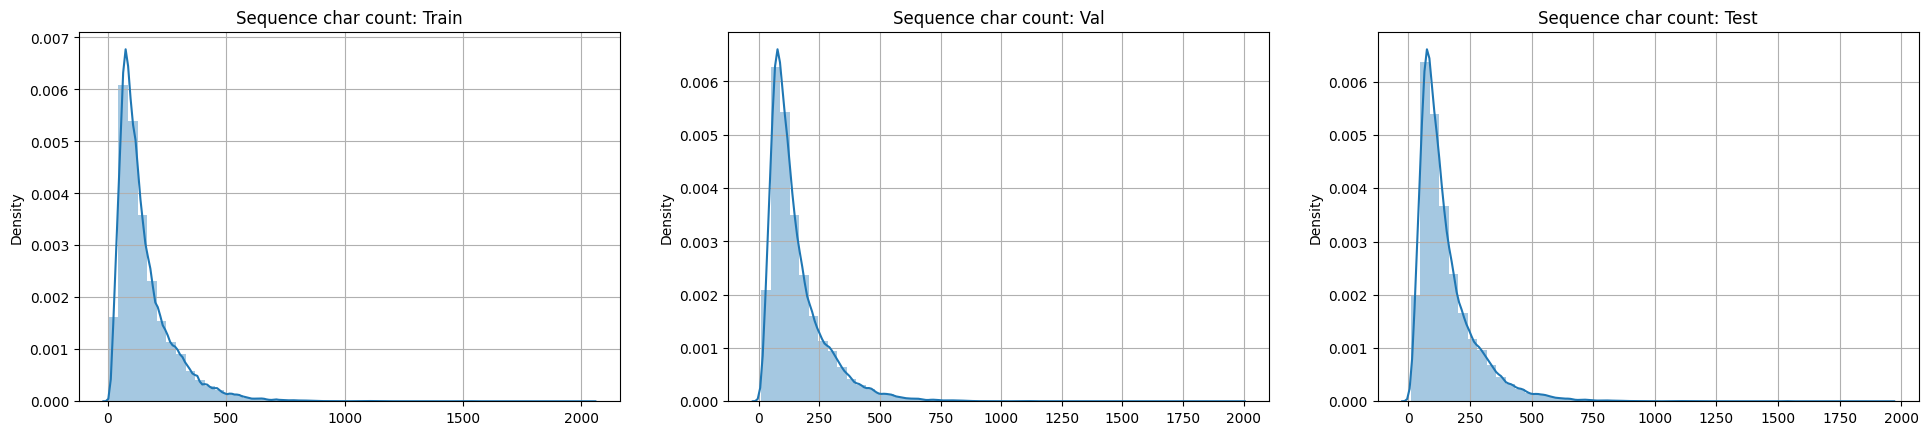

In [15]:
plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observation__
- Most of the unaligned amino acid sequences have character counts in the range of 50-250.

### Sequence Code Frequency

Amino acid sequences are represented with their corresponding 1 letter code, for example, code for alanine is (A), arginine is (R) and so on. The complete list of amino acids with there code can be found <a href='http://www.cryst.bbk.ac.uk/education/AminoAcid/the_twenty.html'>here</a>.

In [16]:
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [17]:
# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')
train_code_freq

Codes: Train
Total unique codes: 25


,Code,Freq
0,L,17062816
1,A,14384873
2,V,11913147
3,G,11845579
4,E,10859966
5,S,10597822
6,I,10234455
7,R,9406165
8,D,9371097
9,K,9127832


In [18]:
# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')
val_code_freq

Codes: Val
Total unique codes: 22


,Code,Freq
0,L,1967025
1,A,1667703
2,V,1382128
3,G,1376124
4,E,1249356
5,S,1210750
6,I,1185722
7,R,1085950
8,D,1080572
9,K,1047638


In [19]:
# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')
test_code_freq

Codes: Test
Total unique codes: 24


,Code,Freq
0,L,1967046
1,A,1668137
2,V,1380962
3,G,1375349
4,E,1251000
5,S,1210559
6,I,1184239
7,R,1085786
8,D,1078379
9,K,1045957


In [20]:
def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

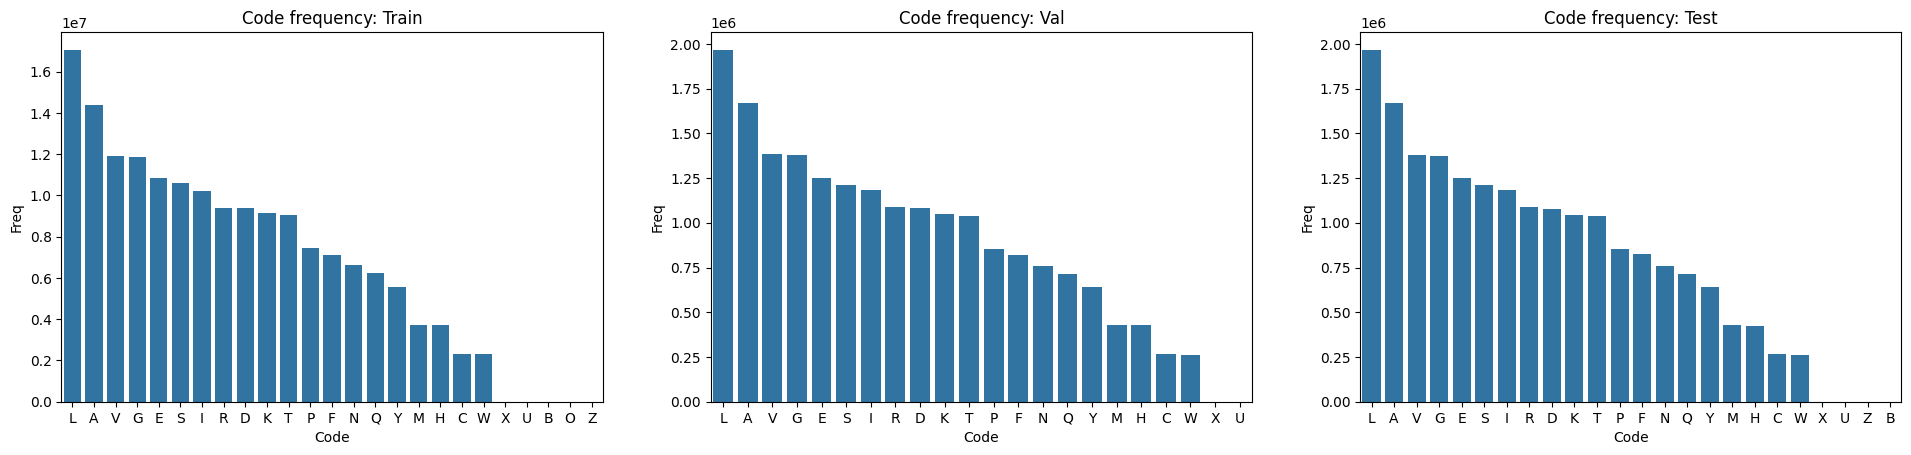

In [21]:
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observations__
- Most frequent amino acid code is L followed by A, V, G.
- As we can see, that the uncommon amino acids (i.e., X, U, B, O, Z) are present in very less quantity. Therefore we can consider only 20 common natural amino acids for sequence encoding.

### Protein families with most sequences(No. of observations)

In [22]:
df_train.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
Lum_binding        1504
DNA_binding_1      1345
Chromate_transp    1265
Lipase_GDSL_2      1252
DnaJ_CXXCXGXG      1210
SRP54_N            1185
WD40               1173
OTCace_N           1171
PEP-utilizers      1147
Glycos_trans_3N    1138
THF_DHG_CYH        1113
Prenyltransf       1104
HTH_1              1064
Maf                1061
DHH                1057
dtype: int64

In [23]:
df_val.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
THF_DHG_CYH        138
Prenyltransf       138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [24]:
df_test.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
THF_DHG_CYH        138
Prenyltransf       138
HTH_1              133
Maf                132
DHH                131
dtype: int64

__Observation__

- Top 20 classes are same across all the sets [train, test, val].
- Test and Val sets have almost same frequency for the top 20 classes.

### Considering 1000 classes based on no. of observations.

In [25]:
# Considering top 1000 classes based on most observations because of limited computational power.

classes = df_train['family_accession'].value_counts()[:1000].index.tolist()
len(classes)

1000

In [26]:
# Filtering data based on considered 1000 classes.
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 1000 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

Data size after considering 1000 classes for each data split:
Train size : 439493
Val size : 54378
Test size : 54378


In [27]:
# No. of unique classes after reducing the data size.

calc_unique_cls(train_sm, test_sm, val_sm)

Number of unique classes in Train:  1000
Number of unique classes in Val:  1000
Number of unique classes in Test:  1000


## 4. Deep Learning Models

### Text Preprocessing

In [28]:
# 1 letter code for 20 natural amino acids

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [29]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list

In [30]:
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm) 

In [31]:
# padding sequences

max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((439493, 100), (54378, 100), (54378, 100))

In [32]:
# One hot encoding of sequences

train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)
test_ohe = to_categorical(test_pad)

train_ohe.shape, test_ohe.shape, test_ohe.shape 

((439493, 100, 21), (54378, 100, 21), (54378, 100, 21))

In [34]:
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((439493,), (54378,), (54378,))

In [35]:
print('Total classes: ', len(le.classes_))
# le.classes_

Total classes:  1000


In [36]:
# One hot encoding of outputs
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

((439493, 1000), (54378, 1000), (54378, 1000))

In [48]:
# # Utility function: plot model's accuracy and loss

# plt.style.use('ggplot')

# def plot_history(history):
#   acc = history.history['acc']
#   val_acc = history.history['val_acc']
#   loss = history.history['loss']
#   val_loss = history.history['val_loss']
#   x = range(1, len(acc) + 1)

#   plt.figure(figsize=(12, 5))
#   plt.subplot(1, 2, 1)
#   plt.plot(x, acc, 'b', label='Training acc')
#   plt.plot(x, val_acc, 'r', label='Validation acc')
#   plt.title('Training and validation accuracy')
#   plt.legend()

#   plt.subplot(1, 2, 2)
#   plt.plot(x, loss, 'b', label='Training loss')
#   plt.plot(x, val_loss, 'r', label='Validation loss')
#   plt.title('Training and validation loss')
#   plt.legend()

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [38]:
# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

### Model 2: ProtCNN (https://www.biorxiv.org/content/10.1101/626507v4.full)

<br/>
<center><img src='https://www.biorxiv.org/content/biorxiv/early/2019/07/15/626507/F6.large.jpg' height='470' width='700'></center>

<br/>

- One hot encoded unaligned sequence of amino acids is passed as the input to the network with zero padding.

- This network uses residual blocks inspired from [ResNet](https://arxiv.org/abs/1512.03385) architecture which also includes dilated convolutions offering larger receptive field without increasing number of model parameters.

In [39]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [40]:
# model

x_input = Input(shape=(100, 21))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(1000, activation='softmax', kernel_regularizer=l2(0.0001))(x)

model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

2024-05-11 15:03:59.474220: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-11 15:03:59.474610: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-11 15:03:59.474629: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-11 15:03:59.474990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-11 15:03:59.475009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 21)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 128)  │      2,816 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 128)  │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 100, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 128)  │     16,512 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 100, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 128)  │     49,280 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 128)  │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 100, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 100, 128)  │     16,512 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 100, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 100, 128)  │     49,280 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 128)  │          0 │ conv1d_4[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 33, 128)   │          0 │ add_1[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 33, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4224)      │          0 │ dropout[0][0]   

 Total params: 4,361,448 (16.64 MB)

 Trainable params: 4,360,424 (16.63 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [41]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [42]:
with tf.device('/device:GPU:0'):
    history2 = model2.fit(
        train_ohe, y_train,
        epochs=10, batch_size=256,
        validation_data=(val_ohe, y_val),
        callbacks=[es]
        )

Epoch 1/10


2024-05-11 15:04:18.372041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1717/1717 ━━━━━━━━━━━━━━━━━━━━ 151s 85ms/step - accuracy: 0.8271 - loss: 1.6675 - val_accuracy: 0.9854 - val_loss: 0.4571
Epoch 2/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 183s 107ms/step - accuracy: 0.9828 - loss: 0.4217 - val_accuracy: 0.9850 - val_loss: 0.4446
Epoch 3/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 174s 101ms/step - accuracy: 0.9838 - loss: 0.4189 - val_accuracy: 0.9864 - val_loss: 0.4361
Epoch 4/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 201s 117ms/step - accuracy: 0.9857 - loss: 0.4033 - val_accuracy: 0.9849 - val_loss: 0.4358
Epoch 5/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 201s 117ms/step - accuracy: 0.9860 - loss: 0.3971 - val_accuracy: 0.9860 - val_loss: 0.4226
Epoch 6/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 185s 107ms/step - accuracy: 0.9861 - loss: 0.3909 - val_accuracy: 0.9867 - val_loss: 0.4208
Epoch 7/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 186s 108ms/step - accuracy: 0.9862 - loss: 0.3893 - val_accuracy: 0.9861 - val_loss: 0.4141
Epoch 8/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 183s 107ms/step - accuracy: 0.98

In [44]:
# saving model weights.
model2.save_weights('/Users/rishabhindoria/Desktop/protein/model_protCNN.weights.h5')

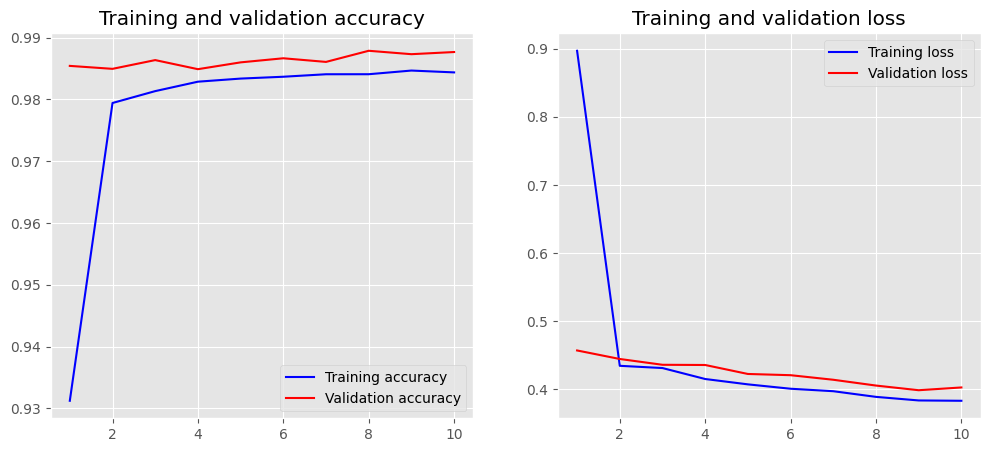

In [49]:
plot_history(history2)

In [46]:
display_model_score(
    model2,
    [train_ohe, y_train],
    [val_ohe, y_val],
    [test_ohe, y_test],
    256)

1717/1717 ━━━━━━━━━━━━━━━━━━━━ 53s 31ms/step - accuracy: 0.9967 - loss: 0.3604
Train loss:  0.36089441180229187
Train accuracy:  0.9966461062431335
----------------------------------------------------------------------
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9879 - loss: 0.4021
Val loss:  0.4028192162513733
Val accuracy:  0.9876788258552551
----------------------------------------------------------------------
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9875 - loss: 0.4033
Test loss:  0.4040759801864624
Test accuracy:  0.9877156019210815


## 5. Conclusion

In [50]:
x = PrettyTable()
x.field_names = ['Sr.no', 'Model', 'Train Acc', 'Val Acc','Test Acc']
x.add_row(['1.', 'ProtCNN', '0.996', '0.987', '0.987'])

print(x)

+-------+---------+-----------+---------+----------+
| Sr.no |  Model  | Train Acc | Val Acc | Test Acc |
+-------+---------+-----------+---------+----------+
|   1.  | ProtCNN |   0.996   |  0.987  |  0.987   |
+-------+---------+-----------+---------+----------+


### Reference:

- https://www.biorxiv.org/content/10.1101/626507v4.full